## StateFarm Kaggle Notebook

In [13]:
%matplotlib inline
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '../utils'))
from utils import *
from PIL import Image
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix
import pandas as pd

In [4]:
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data'
categories = sorted([os.path.basename(x) for x in glob(DATA_HOME_DIR+'/train/*')])
categories

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

## Finetuning and Training

    c0: safe driving
    c1: texting - right
    c2: talking on the phone - right
    c3: texting - left
    c4: talking on the phone - left
    c5: operating the radio
    c6: drinking
    c7: reaching behind
    c8: hair and makeup
    c9: talking to passenger


In [ ]:
def plot_history(h):
    plt.plot(h['acc'])
    plt.plot(h['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def underfit(train_err, test_error):
    return train_err < test_error * 0.667

def overfit(train_acc, test_acc):
    return train_acc > test_acc



In [48]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
#path = DATA_HOME_DIR + '/'
path = DATA_HOME_DIR + '/sample/'

test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

histories = {}

/home/rallen/Documents/Devel/PracticalDL4C/kaggle/statefarm/data


In [111]:
# use the batch normalization VGG
vgg = Vgg16BN()

/home/rallen/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_10 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [112]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=64
no_of_epochs=30

In [113]:
# Augment the data
gen = image.ImageDataGenerator(rotation_range=15, #=0, 
                               height_shift_range=0.05,#=0.1, 
                               width_shift_range=0.1, 
                               shear_range=0.05,#=0
                               channel_shift_range=20,#=0
                               #zoom_range=0.1
                               #, horizontal_flip=True
                              )

In [114]:
# Finetune the model
# just add gen as 2nd parameter to batches & not val_batches
batches = vgg.get_batches(train_path, gen, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

Found 200 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [115]:
INIT_LR0=0.00001
INIT_LR=0.001
EPOCHS_DROP=5.0
DROP=0.5

def step_decay0(epoch, initial_lrate = INIT_LR0, epochs_drop = EPOCHS_DROP, drop = DROP):
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

def step_decay(epoch, initial_lrate = INIT_LR, epochs_drop = EPOCHS_DROP, drop = DROP):
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [116]:
#latest_weights_filename="weights-02-04-1.00.hdf5"
#vgg.model.load_weights(results_path+latest_weights_filename)

#run_index=0 # restarting fresh
run_index+=1
filepath=results_path+"run-%02d-weights-{epoch:02d}-{val_acc:.2f}.hdf5"%(run_index)
history_filepath=results_path+"run-%02d-history.csv"%(run_index)

checkpoint = ModelCheckpoint(filepath, 
                             #monitor='val_acc', mode='max',
                             monitor='val_loss', mode='min',
                             verbose=1, 
                             save_weights_only=True, save_best_only=True)
lr_scheduler0 = LearningRateScheduler(step_decay0)
lr_scheduler = LearningRateScheduler(step_decay)

callbacks = [checkpoint,lr_scheduler]

In [117]:
# okay, so he says we need to first start with super-low learning rate just to get things started
history0 = vgg.fit(batches, val_batches, 3, [checkpoint,lr_scheduler0])
# then, let's try again with more reasonable learning rate
history = vgg.fit(batches, val_batches, no_of_epochs, callbacks)
history_df = pd.DataFrame(history.history)
history_df.to_csv(history_filepath)
histories[run_index] = history_df

Epoch 1/3
200/200 [==============================] - 5s - loss: 6.5586 - acc: 0.0850 - val_loss: 4.1779 - val_acc: 0.1400
Epoch 2/3
200/200 [==============================] - 5s - loss: 6.7021 - acc: 0.0600 - val_loss: 4.1279 - val_acc: 0.1400
Epoch 3/3
200/200 [==============================] - 4s - loss: 6.3836 - acc: 0.0750 - val_loss: 4.0866 - val_acc: 0.1400
Epoch 1/30
200/200 [==============================] - 5s - loss: 5.9898 - acc: 0.1050 - val_loss: 3.6860 - val_acc: 0.1000
Epoch 2/30
200/200 [==============================] - 3s - loss: 5.2349 - acc: 0.1500 - val_loss: 3.7786 - val_acc: 0.1000
Epoch 3/30
200/200 [==============================] - 4s - loss: 5.3901 - acc: 0.1200 - val_loss: 3.5787 - val_acc: 0.1000
Epoch 4/30
200/200 [==============================] - 4s - loss: 4.6493 - acc: 0.1950 - val_loss: 3.1128 - val_acc: 0.1600
Epoch 5/30
200/200 [==============================] - 4s - loss: 4.1197 - acc: 0.2100 - val_loss: 2.9777 - val_acc: 0.2600
Epoch 6/30
200/200 

In [118]:
histories.keys()

[3, 4, 5, 9, 10, 11]

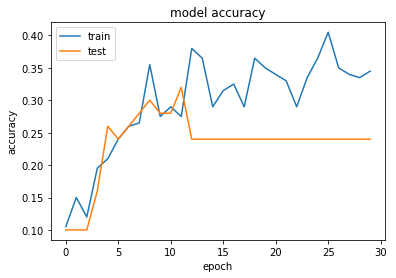

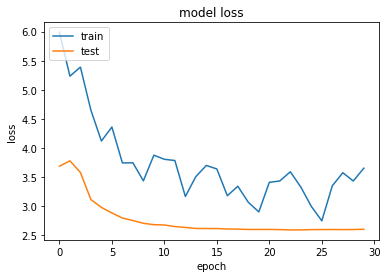

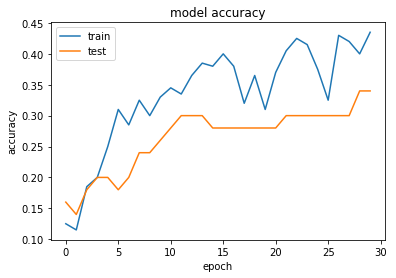

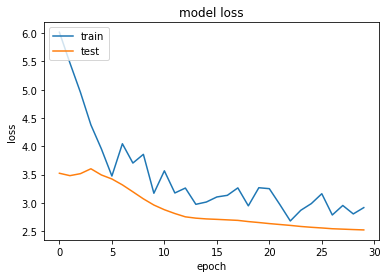

In [119]:
history_df["underfit"] = map(underfit, history_df["loss"], history_df["val_loss"])
history_df["overfit"] = map(overfit, history_df["acc"], history_df["val_acc"])

plot_history(histories[11])
plot_history(histories[10])

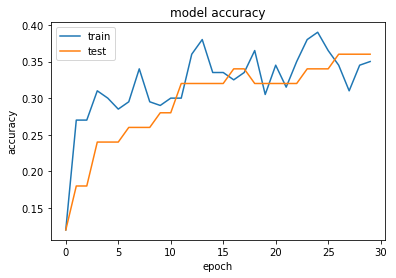

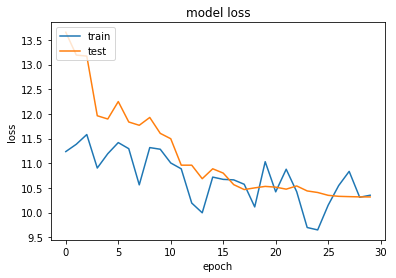

In [34]:
history_df["underfit"] = map(underfit, history_df["loss"], history_df["val_loss"])
history_df["overfit"] = map(overfit, history_df["acc"], history_df["val_acc"])

plot_history(history_df)

In [17]:
history_df

,acc,loss,val_acc,val_loss,underfit,overfit
0,0.135,10.947845,0.16,13.474635,False,False
1,0.220,12.334131,0.08,14.627223,False,True
2,0.275,11.574707,0.10,14.230557,False,True
3,0.230,12.260824,0.12,14.105195,False,True
4,0.250,11.738409,0.10,14.318303,False,True
5,0.250,12.047771,0.10,14.496415,False,True
6,0.235,12.090104,0.10,14.506286,False,True
7,0.265,11.751559,0.10,14.506286,False,True
8,0.265,11.819501,0.10,14.087747,False,True
9,0.255,11.925594,0.14,13.565876,False,True


## Validate Predictions

In [67]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)
filenames = val_batches.filenames
expected_labels = val_batches.classes # 0 - 7

#Round our predictions to 0/1 to generate labels
#our_predictions = probs[:,0]
#our_labels = np.round(1-our_predictions)
our_labels = np.argmax(probs, axis=1)

Found 50 images belonging to 10 classes.


In [68]:
our_labels

array([3, 6, 5, 9, 0, 6, 6, 5, 6, 7, 6, 9, 6, 8, 6, 6, 0, 5, 3, 6, 4, 4, 3, 6, 6, 9, 7, 9, 4, 4, 5,
       6, 6, 5, 6, 5, 9, 3, 9, 5, 3, 5, 9, 4, 9, 7, 7, 4, 5, 3])

[[1 0 0 1 0 1 1 0 0 1]
 [0 0 0 0 0 1 3 1 0 0]
 [0 0 0 0 0 0 3 0 1 1]
 [1 0 0 1 0 1 2 0 0 0]
 [0 0 0 1 2 0 2 0 0 0]
 [0 0 0 0 2 0 0 1 0 2]
 [0 0 0 0 0 2 3 0 0 0]
 [0 0 0 1 0 2 0 0 0 2]
 [0 0 0 1 1 1 0 0 0 2]
 [0 0 0 1 1 1 0 2 0 0]]


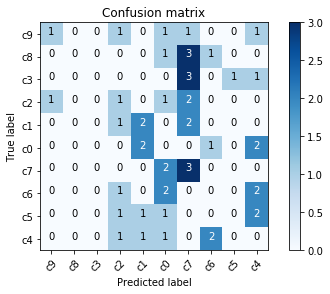

In [69]:
cm = confusion_matrix(expected_labels, our_labels)
plot_confusion_matrix(cm, val_batches.class_indices)